https://www.kaggle.com/vingkan/strategeion-resume-skills

# Interview Success Prediction
#### As a HR recruiter analyst, Given data about resumes, predict whether a candidate will pass their interview at Strategion based on their resumes

In Hiring By Machine, a fictional case study from the Princeton Dialogues on AI and Ethics, developers at the company Strategeion create a machine learning system called PARiS to automatically rank job applicants based on the content of their resumes.

This dataset can be used alongside the case study or as a toy dataset for exploring fairness in machine learning.

Each record has 222 binary features:

218 skill features: whether or not the corresponding skill is on the applicant's resume
4 protected features: demographic information about the applicant

#### Brief history about the company

This was the case for the small, enthusiastic group of Army veterans who co-founded the non-profit company, Strategeion, after having been honorably discharged during the 2008 recession. Building on their previous experiences supporting various military operations with IT solutions, this group of programmers set out to create jobs for themselves and improve the lives of others by producing an online platform that would enable veterans to stay in touch with their cohorts and share experiences dealing with civilian life. 

### Load Data

In [1]:
#import necessary libraries
import pyodbc 
import numpy as np
import pandas as pd

pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix , classification_report, f1_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

SEED = 0

### Connecting to SQL DB

In [2]:
#Python connection to SQL database
    
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=.;'
                      'Database=Interview;'
                      'Trusted_Connection=yes;'
                      'MARS_Connection=Yes;')

cursor = conn.cursor()

#### Connecting to table in SQL DB

In [3]:
#Python connection to SQL resumes_development
cursor.execute('SELECT * FROM Interview.int.resumes_development')

#for row in cursor:
    #print(row)

#### Creating DF

In [5]:
df = pd.read_sql_query('SELECT * FROM Interview.int.resumes_development',conn)

#Checking first 5 rows
df.head()

,column1,Interview,Adobe_Illustrator,Adobe_Photoshop,Agile_Methodologies,Analytical_Skills,Art,Art_Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business_Analysis,Business_Intelligence,Business_Planning,Business_Process,Business_Process_Improvement,Business_Services,Business_Strategy,Change_Management,Coaching,Communication,Company_Research,Construction,Contract_Negotiation,Contractual_Agreements,Customer_Relationship_Management,Customer_Satisfaction,Customer_Service,Data_Analysis,Databases,Decision_Making,Department_of_Defense,Design,Development_Tools,Digital_Marketing,Digital_Media,Diving,Drawing,Ecommerce,Editing,Electronics,Email,Employee_Benefits_Design,Energy,Enterprise_Software,Entrepreneurship,Event_Planning,Facilitation,Facility_Management,Finance,Financial_Analysis,Financial_Reporting,Financial_Risk,Food_and_Beverage,Football,Forecasting,Fundraising,Gas,General_Ledger,Golf,Government_Agencies,Grant_Writing,Graphic_Design,Graphics,Grocery,Gymnastics,HTML,HTML5,Healthcare,Healthcare_Management,Heavy_Equipment,Helping_Clients_Succeed,Higher_Education,History,Hospitality_Industry,Hospitals,Information_Systems,Information_Technology,Insurance,Integrated_Marketing,Integration,Internal_Audit,Interpersonal_Skills,Interviewing,Investments,Invoicing,JQuery,Java,Javascript,Job_Description_Development,Job_Scanning,Joint_Ventures,Journalism,Journals,K12_Education,Kanban,Key_Account_Development,Key_Performance_Indicators,Kindergarten,Knowledge_Base,Knowledge_Management,Knowledge_Sharing,Laboratory_Skills,Leadership,Leadership_Development,Lean_Manufacturing,Legal_Issues,Legal_Writing,Linux,Litigation,Local_Marketing,Logistics_Management,Marine_Corps,Mechanical_Engineering,Medical_Compliance,Military_Aviation,Military_Weapons,Negotiation,Network_Administration,Network_Attached_Storage,Network_Communications,Network_Systems,New_Business_Opportunities,New_Hires,Newsletters,Nonprofit_Organizations,Nutrition,Office_Administration,Online_Advertising,Operating_Systems,Operations_Management,Oracle_Database,Order_Fulfillment,Organizational_Development,Organizational_Structure,Outsourcing,Partnerships,Performance_Tuning,Presentations,Pricing_Strategy,Problem_Solving,Program_Management,Project_Planning,Public_Policy,Public_Relations,Public_Speaking,Qualifying_Prospects,Qualitative_Research,Quality_Auditing,Quality_Improvement,Quality_System,Quantitative_Research,Query_Writing,Queues,QuickBooks,Quotations,Range,Real_Estate,Records,Recruiting,Regulations,Requirements_Analysis,Research,Residential_Homes,Retail,Reviews,SQL,Sales_Management,Schedules,Soccer,Social_Media,Software,Software_Documentation,Staff_Development,Strategic_Planning,Strategy,Supervisory_Skills,Swimming,Teaching,Team_Building,Team_Leadership,Team_Management,Teamwork,Telecommunications,Testing,Time_Management,Training,Troubleshooting,Underwriting,Unified_Modeling_Language,University_Teaching,Unix,User_Acceptance_Testing,User_Experience,User_Interface_Design,Validation,Vendor_Management,Vendors,Video,Video_Editing,Video_Production,Visual_Merchandising,Volleyball,Volunteer_Management,Volunteering,Water_Resource_Management,Web_Applications,Web_Design,Web_Development,Windows,Windows_Server,Wireless_Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Data is clean.

### Step 2: EDA & Data Preprocessing
* What values do you see?
* What distributions do you see?
* What relationships do you see?
* What relationships do you think might benefit the prediction problem?
* What ideas about the domain does the data spark?

In [6]:
#Remove the column 1
df = df.drop(['column1'], axis=1)

In [7]:
#Changing boolean from string (T/F) to integer (1/0)
df[["Veteran", "Female", "URM", "Disability"]] = df[["Veteran", "Female", "URM", "Disability"]].astype(int)

In [8]:
df.head()

,Interview,Adobe_Illustrator,Adobe_Photoshop,Agile_Methodologies,Analytical_Skills,Art,Art_Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business_Analysis,Business_Intelligence,Business_Planning,Business_Process,Business_Process_Improvement,Business_Services,Business_Strategy,Change_Management,Coaching,Communication,Company_Research,Construction,Contract_Negotiation,Contractual_Agreements,Customer_Relationship_Management,Customer_Satisfaction,Customer_Service,Data_Analysis,Databases,Decision_Making,Department_of_Defense,Design,Development_Tools,Digital_Marketing,Digital_Media,Diving,Drawing,Ecommerce,Editing,Electronics,Email,Employee_Benefits_Design,Energy,Enterprise_Software,Entrepreneurship,Event_Planning,Facilitation,Facility_Management,Finance,Financial_Analysis,Financial_Reporting,Financial_Risk,Food_and_Beverage,Football,Forecasting,Fundraising,Gas,General_Ledger,Golf,Government_Agencies,Grant_Writing,Graphic_Design,Graphics,Grocery,Gymnastics,HTML,HTML5,Healthcare,Healthcare_Management,Heavy_Equipment,Helping_Clients_Succeed,Higher_Education,History,Hospitality_Industry,Hospitals,Information_Systems,Information_Technology,Insurance,Integrated_Marketing,Integration,Internal_Audit,Interpersonal_Skills,Interviewing,Investments,Invoicing,JQuery,Java,Javascript,Job_Description_Development,Job_Scanning,Joint_Ventures,Journalism,Journals,K12_Education,Kanban,Key_Account_Development,Key_Performance_Indicators,Kindergarten,Knowledge_Base,Knowledge_Management,Knowledge_Sharing,Laboratory_Skills,Leadership,Leadership_Development,Lean_Manufacturing,Legal_Issues,Legal_Writing,Linux,Litigation,Local_Marketing,Logistics_Management,Marine_Corps,Mechanical_Engineering,Medical_Compliance,Military_Aviation,Military_Weapons,Negotiation,Network_Administration,Network_Attached_Storage,Network_Communications,Network_Systems,New_Business_Opportunities,New_Hires,Newsletters,Nonprofit_Organizations,Nutrition,Office_Administration,Online_Advertising,Operating_Systems,Operations_Management,Oracle_Database,Order_Fulfillment,Organizational_Development,Organizational_Structure,Outsourcing,Partnerships,Performance_Tuning,Presentations,Pricing_Strategy,Problem_Solving,Program_Management,Project_Planning,Public_Policy,Public_Relations,Public_Speaking,Qualifying_Prospects,Qualitative_Research,Quality_Auditing,Quality_Improvement,Quality_System,Quantitative_Research,Query_Writing,Queues,QuickBooks,Quotations,Range,Real_Estate,Records,Recruiting,Regulations,Requirements_Analysis,Research,Residential_Homes,Retail,Reviews,SQL,Sales_Management,Schedules,Soccer,Social_Media,Software,Software_Documentation,Staff_Development,Strategic_Planning,Strategy,Supervisory_Skills,Swimming,Teaching,Team_Building,Team_Leadership,Team_Management,Teamwork,Telecommunications,Testing,Time_Management,Training,Troubleshooting,Underwriting,Unified_Modeling_Language,University_Teaching,Unix,User_Acceptance_Testing,User_Experience,User_Interface_Design,Validation,Vendor_Management,Vendors,Video,Video_Editing,Video_Production,Visual_Merchandising,Volleyball,Volunteer_Management,Volunteering,Water_Resource_Management,Web_Applications,Web_Design,Web_Development,Windows,Windows_Server,Wireless_Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [9]:
df.shape

(619, 223)

In [10]:
df.columns

Index(['Interview', 'Adobe_Illustrator', 'Adobe_Photoshop',
       'Agile_Methodologies', 'Analytical_Skills', 'Art', 'Art_Direction',
       'Auditing', 'AutoCAD', 'Automation',
       ...
       'Windows', 'Windows_Server', 'Wireless_Technologies', 'WordPress',
       'Workshops', 'Writing', 'Veteran', 'Female', 'URM', 'Disability'],
      dtype='object', length=223)

223 attributes! too much! need to do feature engineering

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Columns: 223 entries, Interview to Disability
dtypes: float64(219), int32(4)
memory usage: 1.0 MB


In [12]:
# Get an overall sense of the data shape with the mean/median, min, max, q1, q3 values
df.describe()

,Interview,Adobe_Illustrator,Adobe_Photoshop,Agile_Methodologies,Analytical_Skills,Art,Art_Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business_Analysis,Business_Intelligence,Business_Planning,Business_Process,Business_Process_Improvement,Business_Services,Business_Strategy,Change_Management,Coaching,Communication,Company_Research,Construction,Contract_Negotiation,Contractual_Agreements,Customer_Relationship_Management,Customer_Satisfaction,Customer_Service,Data_Analysis,Databases,Decision_Making,Department_of_Defense,Design,Development_Tools,Digital_Marketing,Digital_Media,Diving,Drawing,Ecommerce,Editing,Electronics,Email,Employee_Benefits_Design,Energy,Enterprise_Software,Entrepreneurship,Event_Planning,Facilitation,Facility_Management,Finance,Financial_Analysis,Financial_Reporting,Financial_Risk,Food_and_Beverage,Football,Forecasting,Fundraising,Gas,General_Ledger,Golf,Government_Agencies,Grant_Writing,Graphic_Design,Graphics,Grocery,Gymnastics,HTML,HTML5,Healthcare,Healthcare_Management,Heavy_Equipment,Helping_Clients_Succeed,Higher_Education,History,Hospitality_Industry,Hospitals,Information_Systems,Information_Technology,Insurance,Integrated_Marketing,Integration,Internal_Audit,Interpersonal_Skills,Interviewing,Investments,Invoicing,JQuery,Java,Javascript,Job_Description_Development,Job_Scanning,Joint_Ventures,Journalism,Journals,K12_Education,Kanban,Key_Account_Development,Key_Performance_Indicators,Kindergarten,Knowledge_Base,Knowledge_Management,Knowledge_Sharing,Laboratory_Skills,Leadership,Leadership_Development,Lean_Manufacturing,Legal_Issues,Legal_Writing,Linux,Litigation,Local_Marketing,Logistics_Management,Marine_Corps,Mechanical_Engineering,Medical_Compliance,Military_Aviation,Military_Weapons,Negotiation,Network_Administration,Network_Attached_Storage,Network_Communications,Network_Systems,New_Business_Opportunities,New_Hires,Newsletters,Nonprofit_Organizations,Nutrition,Office_Administration,Online_Advertising,Operating_Systems,Operations_Management,Oracle_Database,Order_Fulfillment,Organizational_Development,Organizational_Structure,Outsourcing,Partnerships,Performance_Tuning,Presentations,Pricing_Strategy,Problem_Solving,Program_Management,Project_Planning,Public_Policy,Public_Relations,Public_Speaking,Qualifying_Prospects,Qualitative_Research,Quality_Auditing,Quality_Improvement,Quality_System,Quantitative_Research,Query_Writing,Queues,QuickBooks,Quotations,Range,Real_Estate,Records,Recruiting,Regulations,Requirements_Analysis,Research,Residential_Homes,Retail,Reviews,SQL,Sales_Management,Schedules,Soccer,Social_Media,Software,Software_Documentation,Staff_Development,Strategic_Planning,Strategy,Supervisory_Skills,Swimming,Teaching,Team_Building,Team_Leadership,Team_Management,Teamwork,Telecommunications,Testing,Time_Management,Training,Troubleshooting,Underwriting,Unified_Modeling_Language,University_Teaching,Unix,User_Acceptance_Testing,User_Experience,User_Interface_Design,Validation,Vendor_Management,Vendors,Video,Video_Editing,Video_Production,Visual_Merchandising,Volleyball,Volunteer_Management,Volunteering,Water_Resource_Management,Web_Applications,Web_Design,Web_Development,Windows,Windows_Server,Wireless_Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
count,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.0

In [13]:
# Look for cells with missing data (i.e. Null or NA)
df.isna().any().any()

False

No null values!

In [14]:
# look at correlations in the numerical independent variables, as well as the dependent variable
df.corr()

,Interview,Adobe_Illustrator,Adobe_Photoshop,Agile_Methodologies,Analytical_Skills,Art,Art_Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business_Analysis,Business_Intelligence,Business_Planning,Business_Process,Business_Process_Improvement,Business_Services,Business_Strategy,Change_Management,Coaching,Communication,Company_Research,Construction,Contract_Negotiation,Contractual_Agreements,Customer_Relationship_Management,Customer_Satisfaction,Customer_Service,Data_Analysis,Databases,Decision_Making,Department_of_Defense,Design,Development_Tools,Digital_Marketing,Digital_Media,Diving,Drawing,Ecommerce,Editing,Electronics,Email,Employee_Benefits_Design,Energy,Enterprise_Software,Entrepreneurship,Event_Planning,Facilitation,Facility_Management,Finance,Financial_Analysis,Financial_Reporting,Financial_Risk,Food_and_Beverage,Football,Forecasting,Fundraising,Gas,General_Ledger,Golf,Government_Agencies,Grant_Writing,Graphic_Design,Graphics,Grocery,Gymnastics,HTML,HTML5,Healthcare,Healthcare_Management,Heavy_Equipment,Helping_Clients_Succeed,Higher_Education,History,Hospitality_Industry,Hospitals,Information_Systems,Information_Technology,Insurance,Integrated_Marketing,Integration,Internal_Audit,Interpersonal_Skills,Interviewing,Investments,Invoicing,JQuery,Java,Javascript,Job_Description_Development,Job_Scanning,Joint_Ventures,Journalism,Journals,K12_Education,Kanban,Key_Account_Development,Key_Performance_Indicators,Kindergarten,Knowledge_Base,Knowledge_Management,Knowledge_Sharing,Laboratory_Skills,Leadership,Leadership_Development,Lean_Manufacturing,Legal_Issues,Legal_Writing,Linux,Litigation,Local_Marketing,Logistics_Management,Marine_Corps,Mechanical_Engineering,Medical_Compliance,Military_Aviation,Military_Weapons,Negotiation,Network_Administration,Network_Attached_Storage,Network_Communications,Network_Systems,New_Business_Opportunities,New_Hires,Newsletters,Nonprofit_Organizations,Nutrition,Office_Administration,Online_Advertising,Operating_Systems,Operations_Management,Oracle_Database,Order_Fulfillment,Organizational_Development,Organizational_Structure,Outsourcing,Partnerships,Performance_Tuning,Presentations,Pricing_Strategy,Problem_Solving,Program_Management,Project_Planning,Public_Policy,Public_Relations,Public_Speaking,Qualifying_Prospects,Qualitative_Research,Quality_Auditing,Quality_Improvement,Quality_System,Quantitative_Research,Query_Writing,Queues,QuickBooks,Quotations,Range,Real_Estate,Records,Recruiting,Regulations,Requirements_Analysis,Research,Residential_Homes,Retail,Reviews,SQL,Sales_Management,Schedules,Soccer,Social_Media,Software,Software_Documentation,Staff_Development,Strategic_Planning,Strategy,Supervisory_Skills,Swimming,Teaching,Team_Building,Team_Leadership,Team_Management,Teamwork,Telecommunications,Testing,Time_Management,Training,Troubleshooting,Underwriting,Unified_Modeling_Language,University_Teaching,Unix,User_Acceptance_Testing,User_Experience,User_Interface_Design,Validation,Vendor_Management,Vendors,Video,Video_Editing,Video_Production,Visual_Merchandising,Volleyball,Volunteer_Management,Volunteering,Water_Resource_Management,Web_Applications,Web_Design,Web_Development,Windows,Windows_Server,Wireless_Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
Interview,1.000000,-0.099526,-0.062321,0.174166,-0.072661,-0.005198,-0.062321,-0.099526,-0.148607,-0.087295,-0.105544,0.274150,0.160128,-0.044385,0.154332,-0.024840,-0.079134,-0.069046,-0.131672,-0.082995,-0.020974,-0.073952,-0.079532,0.139520,-0.089877,-0.064009,-0.099237,-0.079532,-0.099237,0.170416,-0.077882,-0.101334,0.145878,0.214220,0.195243,0.149385,-0.099237,-0.047181,0.220260,-0.067730,0.180836,-0.072661,-0.116606,-0.077882,-0.107946,-0.072661,-0.116098,0.185017,-0.104037,-0.044385,-0.054754,-0.068017,-0.131672,-0.062321,-0.089834,-0.030522,-0.103669,0.129065,0.221028,-0.103669,-0.041217,-0.116606,-0.112559,-0.072661,0.153089,-0.077945,-0.061249,-0.103669,-0.077882,-0.082995,

In [15]:
# As this is a classification exercise, we will check whether the target (dependent variable) is imbalanced
df['Interview'].value_counts()

0.0    400
1.0    219
Name: Interview, dtype: int64

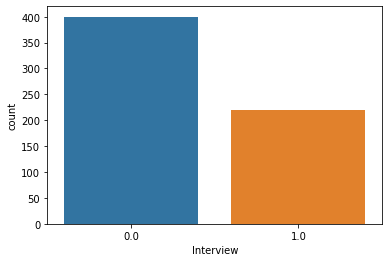

In [16]:
# To visualize how well balanced the target (dependent variable) is
_ = sns.countplot(x=df['Interview'])

Ok i suppose? not very imbalanced and yet not so balanced.

# correlation matrix heatmap visualization
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(df.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(30,25))

# Plot the heatmap
_ = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={"size": 12}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')  # annot=True display corr label

# _ = sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, square=True, 
#                 cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')

# Prevent Heatmap Cut-Off Issue
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom+0.5, top-0.5)

# Visualize correlations drilled down by dependent variable
_ = sns.pairplot(df, corner=True, hue='Interview')

# Lets start by looking at the continuous variables

cvars = [i for i in df.columns if df[i].dtypes !='object']
fig,ax = plt.subplots(1,3,figsize=(50,40))

for i,x in enumerate(cvars):
    ax[i].hist(df[x][df.Interview==0],label='InterviewSuccess=0',bins=30)
    ax[i].hist(df[x][df.Interview==1],label='InterviewSuccess=1',bins=30)
    ax[i].set(xlabel=x,ylabel='count')
    ax[i].legend()

### Step 3: Preparing the data for training and testing

1) Divide our independent and dependent variable into two separate variables.

2) Split the data into training and testing datasets.

#### Preprocessing data


from sklearn.feature_selection import SelectPercentile, chi2

In [17]:
df = df.copy()
    
#Remove index column 1 & interview and split into X & y
X = df.drop(['Interview'], axis=1) # input
y = df['Interview'] # output (dependent variable)

In [18]:
X.shape

(619, 222)

In [19]:
#Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X ,y, 
                                                test_size = 0.3, 
                                                shuffle=True, 
                                                stratify=y,
                                                random_state=SEED)

In [20]:
X_train.head()

,Adobe_Illustrator,Adobe_Photoshop,Agile_Methodologies,Analytical_Skills,Art,Art_Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business_Analysis,Business_Intelligence,Business_Planning,Business_Process,Business_Process_Improvement,Business_Services,Business_Strategy,Change_Management,Coaching,Communication,Company_Research,Construction,Contract_Negotiation,Contractual_Agreements,Customer_Relationship_Management,Customer_Satisfaction,Customer_Service,Data_Analysis,Databases,Decision_Making,Department_of_Defense,Design,Development_Tools,Digital_Marketing,Digital_Media,Diving,Drawing,Ecommerce,Editing,Electronics,Email,Employee_Benefits_Design,Energy,Enterprise_Software,Entrepreneurship,Event_Planning,Facilitation,Facility_Management,Finance,Financial_Analysis,Financial_Reporting,Financial_Risk,Food_and_Beverage,Football,Forecasting,Fundraising,Gas,General_Ledger,Golf,Government_Agencies,Grant_Writing,Graphic_Design,Graphics,Grocery,Gymnastics,HTML,HTML5,Healthcare,Healthcare_Management,Heavy_Equipment,Helping_Clients_Succeed,Higher_Education,History,Hospitality_Industry,Hospitals,Information_Systems,Information_Technology,Insurance,Integrated_Marketing,Integration,Internal_Audit,Interpersonal_Skills,Interviewing,Investments,Invoicing,JQuery,Java,Javascript,Job_Description_Development,Job_Scanning,Joint_Ventures,Journalism,Journals,K12_Education,Kanban,Key_Account_Development,Key_Performance_Indicators,Kindergarten,Knowledge_Base,Knowledge_Management,Knowledge_Sharing,Laboratory_Skills,Leadership,Leadership_Development,Lean_Manufacturing,Legal_Issues,Legal_Writing,Linux,Litigation,Local_Marketing,Logistics_Management,Marine_Corps,Mechanical_Engineering,Medical_Compliance,Military_Aviation,Military_Weapons,Negotiation,Network_Administration,Network_Attached_Storage,Network_Communications,Network_Systems,New_Business_Opportunities,New_Hires,Newsletters,Nonprofit_Organizations,Nutrition,Office_Administration,Online_Advertising,Operating_Systems,Operations_Management,Oracle_Database,Order_Fulfillment,Organizational_Development,Organizational_Structure,Outsourcing,Partnerships,Performance_Tuning,Presentations,Pricing_Strategy,Problem_Solving,Program_Management,Project_Planning,Public_Policy,Public_Relations,Public_Speaking,Qualifying_Prospects,Qualitative_Research,Quality_Auditing,Quality_Improvement,Quality_System,Quantitative_Research,Query_Writing,Queues,QuickBooks,Quotations,Range,Real_Estate,Records,Recruiting,Regulations,Requirements_Analysis,Research,Residential_Homes,Retail,Reviews,SQL,Sales_Management,Schedules,Soccer,Social_Media,Software,Software_Documentation,Staff_Development,Strategic_Planning,Strategy,Supervisory_Skills,Swimming,Teaching,Team_Building,Team_Leadership,Team_Management,Teamwork,Telecommunications,Testing,Time_Management,Training,Troubleshooting,Underwriting,Unified_Modeling_Language,University_Teaching,Unix,User_Acceptance_Testing,User_Experience,User_Interface_Design,Validation,Vendor_Management,Vendors,Video,Video_Editing,Video_Production,Visual_Merchandising,Volleyball,Volunteer_Management,Volunteering,Water_Resource_Management,Web_Applications,Web_Design,Web_Development,Windows,Windows_Server,Wireless_Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [21]:
y_train.value_counts()

0.0    280
1.0    153
Name: Interview, dtype: int64

222 features to do is not practical. so need to do feature selection to pick out the ones that explains the most. Will use SelectKBest with chi2! First to test on all 222 features to check how many features (k-value) are highest graphically.
<br></br>
And then using the selected k-value to fit and transform X_train and y_train and X_test data.

## How many kbest - values to select

In [22]:
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [23]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 3.825000
Feature 1: 0.560942
Feature 2: 5.708458
Feature 3: 1.029169
Feature 4: 1.331261
Feature 5: 0.124559
Feature 6: 4.371429
Feature 7: 9.289286
Feature 8: 4.133335
Feature 9: 4.869750
Feature 10: 31.728581
Feature 11: 7.974126
Feature 12: 1.029169
Feature 13: 12.197069
Feature 14: 0.188247
Feature 15: 2.732143
Feature 16: 2.745390
Feature 17: 7.650000
Feature 18: 3.828994
Feature 19: 0.941235
Feature 20: 2.809078
Feature 21: 2.311277
Feature 22: 6.604649
Feature 23: 2.185714
Feature 24: 1.543754
Feature 25: 1.825633
Feature 26: 0.514585
Feature 27: 3.828994
Feature 28: 14.237536
Feature 29: 2.714713
Feature 30: 4.133335
Feature 31: 16.729299
Feature 32: 16.712626
Feature 33: 15.559070
Feature 34: 5.459162
Feature 35: 3.315720
Feature 36: 0.514585
Feature 37: 9.318824
Feature 38: 1.543754
Feature 39: 9.399036
Feature 40: 1.029169
Feature 41: 5.464286
Feature 42: 3.315720
Feature 43: 5.395338
Feature 44: 1.830260
Feature 45: 6.557143
Feature 46: 11.796989
Feature 47: 3.82

In [24]:
(fs.scores_).min()

0.005095068330362454

In [25]:
# plot the scores
plt.figure(figsize=(230,100))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

maybe 20 features seem important!

### Feature Selection

In [26]:
# feature selection

fs = SelectKBest(score_func=chi2, k=20)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
mask = fs.get_support()


In [27]:
X_train_fs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 1., 1.]])

# feature selection

In [28]:
#To get the selected feature names
feature_names = list(X.columns.values)

mask = fs.get_support()  #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

In [29]:
new_features

['Baseball',
 'Budgeting',
 'Customer_Relationship_Management',
 'Data_Analysis',
 'Databases',
 'Decision_Making',
 'Energy',
 'Football',
 'Healthcare',
 'Information_Technology',
 'Interpersonal_Skills',
 'Logistics_Management',
 'Military_Aviation',
 'Oracle_Database',
 'Performance_Tuning',
 'Soccer',
 'Swimming',
 'Volunteering',
 'Veteran',
 'Disability']

In [30]:
X_df = pd.DataFrame(X_train_fs, columns=new_features)
X_df 

,Baseball,Budgeting,Customer_Relationship_Management,Data_Analysis,Databases,Decision_Making,Energy,Football,Healthcare,Information_Technology,Interpersonal_Skills,Logistics_Management,Military_Aviation,Oracle_Database,Performance_Tuning,Soccer,Swimming,Volunteering,Veteran,Disability
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
430,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [113]:
dfx_corr = X_df.corr()

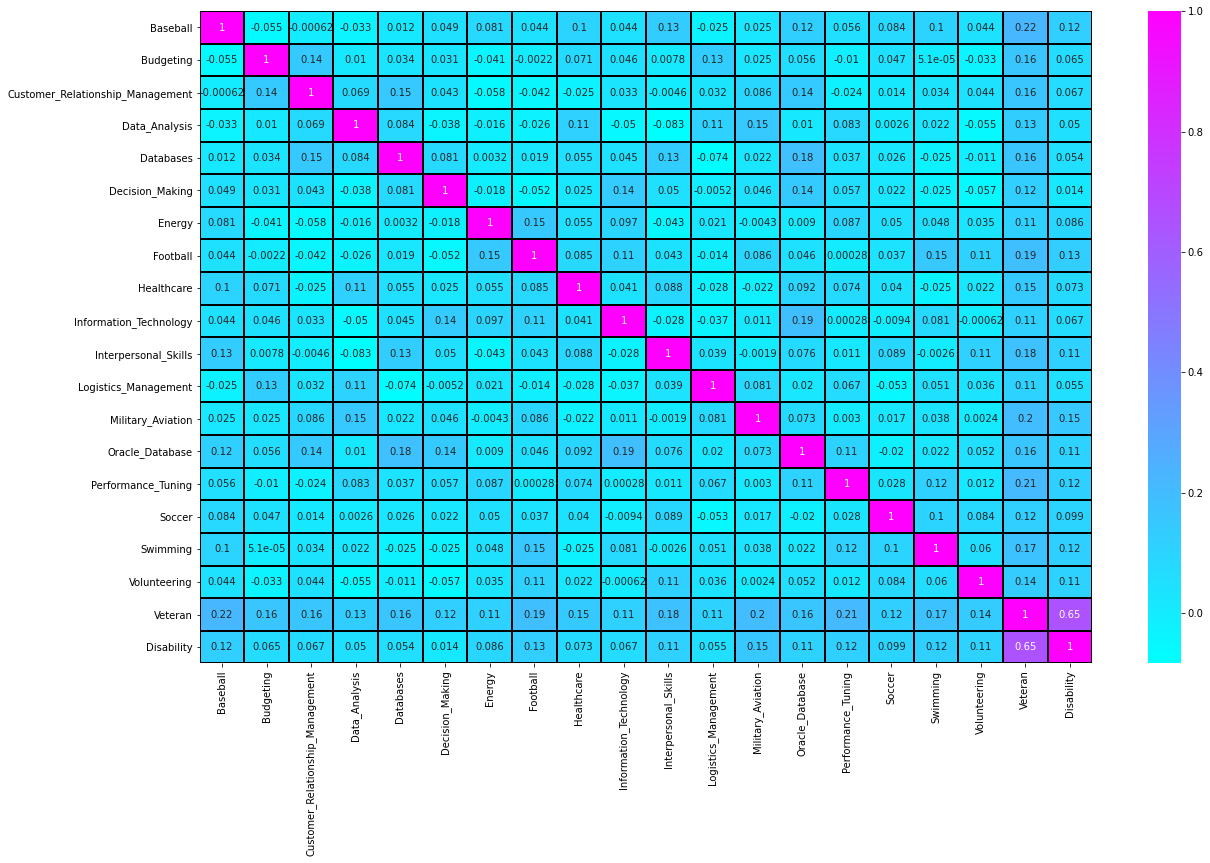

In [129]:
corrMatrix = dfx_corr
plt.figure(figsize=(20,12))
sns.heatmap(corrMatrix, annot=True,cmap= 'cool', linewidths=1, linecolor='black')
plt.show()

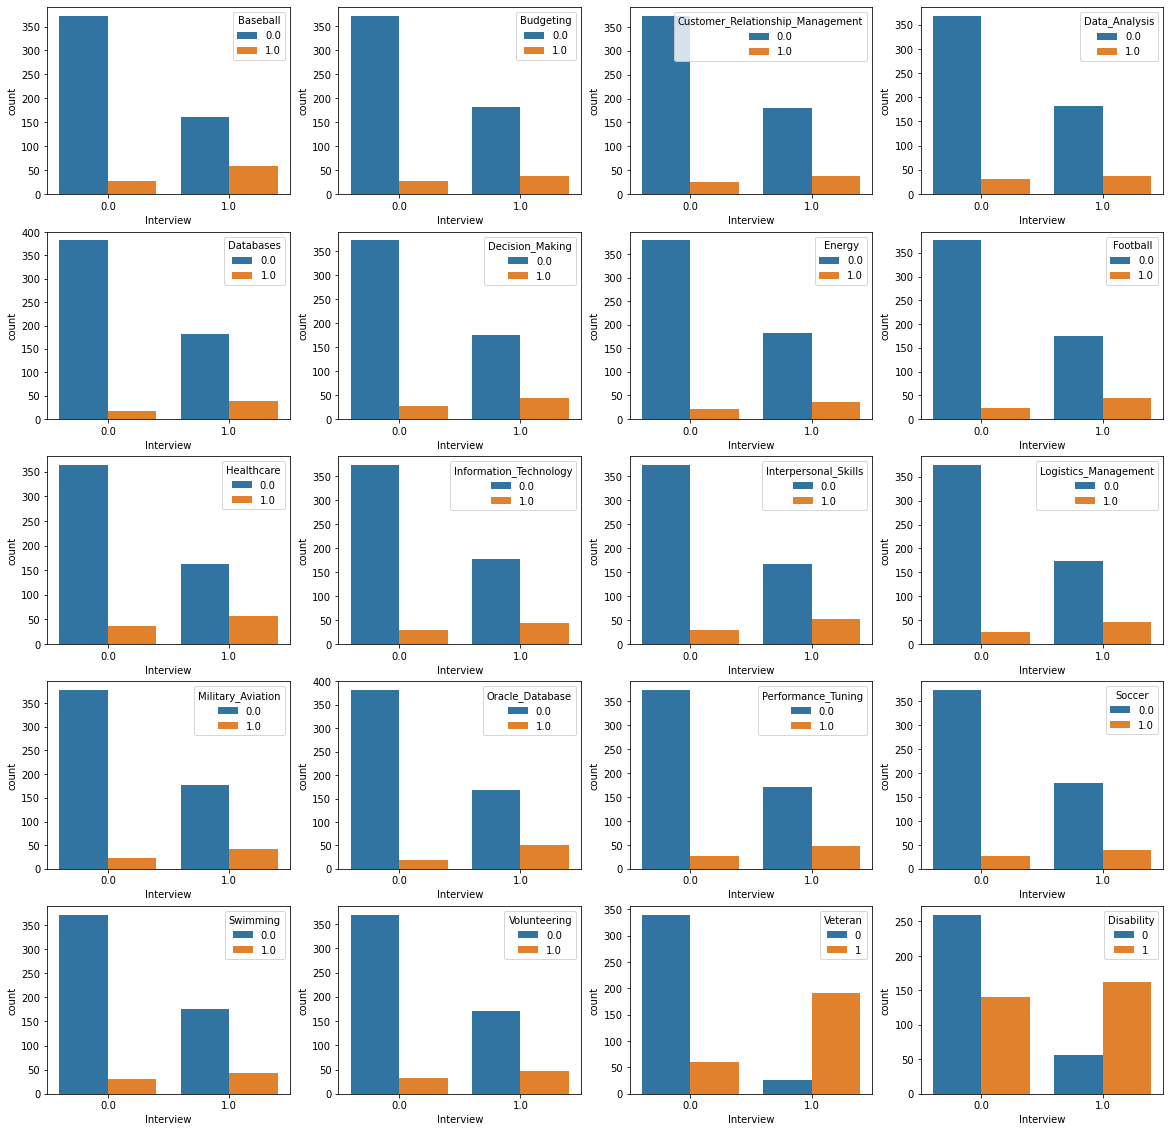

In [105]:
# Let's look at all the categorical variables and their impact on interview

# Removing interview variable for analysis
categorical_var = X_df 
catVars_ = categorical_var[:-1]

fig ,ax = plt.subplots(5,4,figsize=(20,20))
for axi ,var in zip(ax.flat,catVars_):
    sns.countplot(x=df.Interview,hue=df[var],ax=axi)

<AxesSubplot:xlabel='Veteran', ylabel='count'>

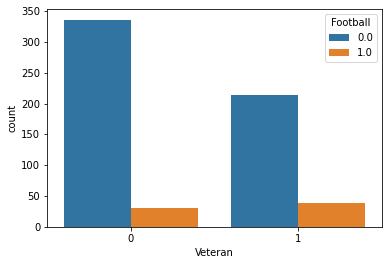

In [102]:
sns.countplot(x=df.Veteran,hue=df['Football'])

<AxesSubplot:xlabel='Veteran', ylabel='count'>

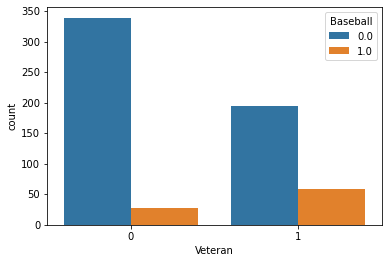

In [99]:
sns.countplot(x=df.Veteran,hue=df['Baseball'])


<AxesSubplot:xlabel='Veteran', ylabel='count'>

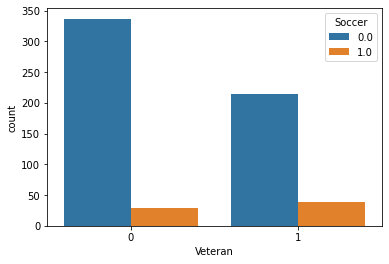

In [100]:
sns.countplot(x=df.Veteran,hue=df['Soccer'])


This is USA HR settings.
In general, there are more unsuccessful interviews than successful ones. Which could be due to the slightly imbalanced data received.
Sports seems to be a popular features in successful interviews. Why? Soccer, football, swimming and baseball are in the top 20 feature selection with higher success count.

Next is a group of IT features. As this is IT related company offering IT products to their customers, 
being a veteran and having disability are easier to be successful at their interviews. Which could be true due to the fact that the company being a military background owners tend to look out for their army buddies in their hiring practices thus higher. 

#### Training the models

#### A. Baseline model using Logistic Regression

In [162]:
# Lists to keep track of model metrics
models = []
precision_list = []
recall_list = []
f1_score_list = []
training_acc_list = []
testing_acc_list = []
training_time_list = []
best_params_list = []
best_param_score_list = []
date_time = []
auc_roc_list = []

In [163]:
timestamp = datetime.datetime.now()
logreg = LogisticRegression()

In [164]:
# K-fold cross validation using F1-score as scorer
scores = cross_val_score(logreg, 
                         X_train_fs, 
                         y_train, 
                         cv=5, 
                         scoring='f1_macro')
print('F1 scores:', scores)
print('Mean & standard deviation: {:.2} {:.2f}'.format(scores.mean(), np.std(scores)))

F1 scores: [0.9116495  0.85895357 0.9023569  0.9205665  0.94880952]
Mean & standard deviation: 0.91 0.03


In [35]:
baseline_model = pd.DataFrame({'F1_scores'})

data = {'Created_on': [timestamp],
        'BaseLine_Model': ['Logistic Regression'],
        'Cross_Validation':  ['Yes'],
        'cv1':  [scores[0]],
        'cv2': [scores[1]],
        'cv3': [scores[2]],
        'cv4': [scores[3]],
        'cv5': [scores[4]],
        'mean': [np.mean(scores)],
        'std': [np.std(scores)]
        }

baseline_model = pd.DataFrame (data, columns = ['Created_on','Cross_Validation','BaseLine_Model','cv1','cv2','cv3','cv4','cv5','mean','std'])


In [36]:
baseline_model

,Created_on,Cross_Validation,BaseLine_Model,cv1,cv2,cv3,cv4,cv5,mean,std
0,2021-05-26 19:44:46.144650,Yes,Logistic Regression,0.911649,0.858954,0.902357,0.920567,0.94881,0.908467,0.029233


#### average F-1 score of 0.90 and low std of 0.029 which means most of the data are clustered around the mean score

#append to models list
models.append('Logistic Regression (Baseline)')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, logreg.predict(X_train)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

#### Model Selection - Train and evaluate multiple models

#### 1. Logistic Regression with hyperparameter tuning

- n_jobs=1 it uses 100% of the cpu of one of the cores. Each process is run in a different core.

In [195]:
date_time_lr = datetime.datetime.now()

In [196]:
logregh = LogisticRegression(n_jobs=-1)

In [197]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'penalty': ['l2'],
              'C': np.logspace(-2, 2, 5)}

gs_logreg = GridSearchCV(logregh,
                      param_grid, 
                      cv=5,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_logreg.fit(X_train_fs, y_train)

Wall time: 11.4 s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l2']},
             scoring='f1_macro')

In [198]:
# Best model hyperparameters and score
print(gs_logreg.best_estimator_)
print(gs_logreg.best_params_)
print(gs_logreg.best_score_)

LogisticRegression(n_jobs=-1)
{'C': 1.0, 'penalty': 'l2'}
0.9084672004364294


In [199]:
# Using best estimator found by GridSearchCV
logregh = gs_logreg.best_estimator_
start_time = time.time()
logregh.fit(X_train_fs, y_train)

training_time_log = time.time() - start_time
training_time_log

0.01598978042602539

In [200]:
y_pred = logregh.predict(X_test_fs)

In [201]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       120
         1.0       0.78      0.76      0.77        66

    accuracy                           0.84       186
   macro avg       0.83      0.82      0.82       186
weighted avg       0.84      0.84      0.84       186



ROC

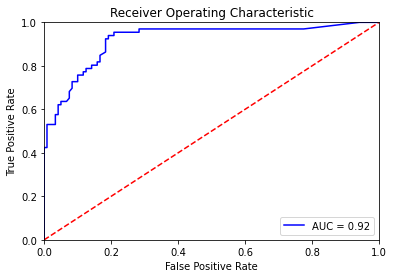

In [202]:
# calculate the fpr and tpr for all thresholds of the classification
probs = logregh.predict_proba(X_test_fs)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_lr = metrics.auc(fpr, tpr)

# plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [203]:
#append to models list
models.append('Logistic Regression with Hyperparameter Tuning')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, logregh.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_log)
best_params_list.append(str(gs_logreg.best_params_))
best_param_score_list.append(gs_logreg.best_score_)
date_time.append(date_time_lr)
auc_roc_list.append(roc_auc_lr)

Text(33.0, 0.5, 'Predicted')

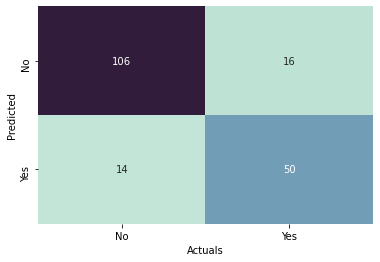

In [205]:
## Confusion Matrix

conf_mat_lrh = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat_lrh.T, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('Actuals')
plt.ylabel('Predicted')

#### 2. Random Forest

In [206]:
date_time_rfc = datetime.datetime.now()

In [207]:
rf_classifier = RandomForestClassifier()
start_time = time.time()
rf_classifier.fit(X_train_fs, y_train)

training_time_rf_classifier = time.time() - start_time
training_time_rf_classifier

0.34545111656188965

In [208]:
y_pred = rf_classifier.predict(X_test_fs)

In [209]:
rf_score = rf_classifier.score(X_test_fs, y_test)
print("Random Forest Classification Test Accuracy: {}%".format(round(rf_score*100,2)))

Random Forest Classification Test Accuracy: 82.26%


In [210]:
# Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87       120
         1.0       0.77      0.71      0.74        66

    accuracy                           0.82       186
   macro avg       0.81      0.80      0.80       186
weighted avg       0.82      0.82      0.82       186



ROC

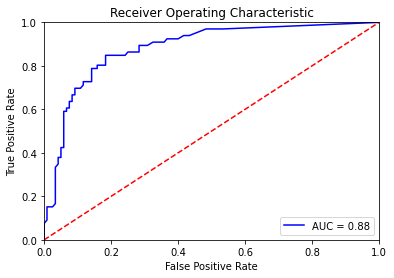

In [211]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_classifier.predict_proba(X_test_fs)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_rf_c = metrics.auc(fpr, tpr)

# plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_rf_c)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [212]:
#append to models list
models.append('Random Forest')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, rf_classifier.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_rf_classifier)
date_time.append(date_time_rfc)
auc_roc_list.append(roc_auc_rf_c)

Text(33.0, 0.5, 'Predicted')

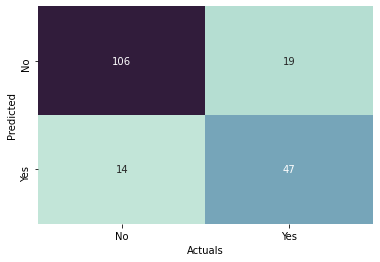

In [213]:
## Confusion Matrix

conf_mat_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat_rf.T, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('Actuals')
plt.ylabel('Predicted')

#### 3. Random Forest with hyperparameter tuning

In [53]:
date_time_rf = datetime.datetime.now()

In [54]:
rf = RandomForestClassifier(n_jobs=-1)

In [55]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 25],
              'min_samples_split': [5, 10, 15]}

gs_rf = GridSearchCV(rf,
                    param_grid, 
                    cv=5,
                    scoring='f1_macro',
                    n_jobs=-1)
gs_rf.fit(X_train_fs, y_train)

Wall time: 1min 14s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 25],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [56]:
# Best model hyperparameters and score
print(gs_rf.best_estimator_)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=10,
                       n_jobs=-1)
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.91016184129978


In [57]:
# Using best estimator found by GridSearchCV
rf = gs_rf.best_estimator_
start_time = time.time()
rf.fit(X_train_fs, y_train)

training_time_rf = time.time() - start_time
training_time_rf

0.33144187927246094

In [58]:
y_pred = rf.predict(X_test_fs)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       120
         1.0       0.74      0.73      0.73        66

    accuracy                           0.81       186
   macro avg       0.79      0.79      0.79       186
weighted avg       0.81      0.81      0.81       186



ROC

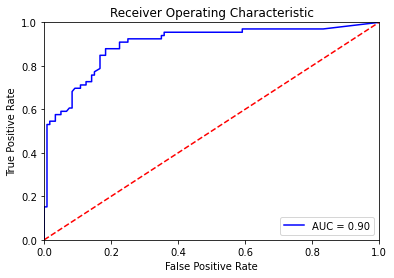

In [60]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(X_test_fs)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_rf = metrics.auc(fpr, tpr)

# plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
roc_auc_rf

0.8998737373737374

In [62]:
models.append('Random Forest with Hyperparameter Tuning')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, rf.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_rf)
best_params_list.append(str(gs_rf.best_params_))
best_param_score_list.append(gs_rf.best_score_)
date_time.append(date_time_rf)
auc_roc_list.append(roc_auc_rf)

#### 4. Decision Tree

date_time_dtc = datetime.datetime.now()

dt_classifier = DecisionTreeClassifier()

start_time=time.time()
dt_classifier.fit(X_train_fs, y_train)

training_time_dt_classifier = time.time() - start_time
training_time_dt_classifier

y_pred = dt_classifier.predict(X_test_fs)

dt_score = dt_classifier.score(X_test_fs, y_test)
print("Random Forest Classification Test Accuracy: {}%".format(round(dt_score*100,2)))

# Classification Report
print(classification_report(y_test,y_pred))

models.append('Decision Tree')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, dt_classifier.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_dt_classifier)
date_time.append(date_time_dtc)

#### 5. Decision Tree with hyperparameter tuning

date_time_dt = datetime.datetime.now()

dt = DecisionTreeClassifier(random_state=SEED)

%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(1,10),
              'min_samples_split': range(2, 50),
              'min_samples_leaf': range(1, 20)}

gs_dt = GridSearchCV(dt,
                      param_grid, 
                      cv=5,
                      scoring='f1_macro',
                      n_jobs=-1)

gs_dt.fit(X_train_fs, y_train)

# Best model hyperparameters and score
print(gs_dt.best_estimator_)
print(gs_dt.best_params_)
print(gs_dt.best_score_)


# Using best estimator found by GridSearchCV
dt = gs_dt.best_estimator_
start_time=time.time()
dt.fit(X_train_fs, y_train)

training_time_dt = time.time() - start_time
training_time_dt

y_pred = dt.predict(X_test_fs)

# Classification Report
print(classification_report(y_test,y_pred))

models.append('Decision Tree with Hyperparameter Tuning')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, dt.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_dt)
best_params_list.append(str(gs_dt.best_params_))
best_param_score_list.append(gs_dt.best_score_)
date_time.append(date_time_dt)


## Decision Tree and MLP classifier doesnt work.. need to find out why

#### 6. MLP

date_time_mlpc = datetime.datetime.now()

mlp_classifier = MLPClassifier(solver='sgd', max_iter = 7000)

start_time=time.time()
mlp_classifier.fit(X_train_fs, y_train)

training_time_mlp_classifier = time.time() - start_time
training_time_mlp_classifier

y_pred = mlp_classifier.predict(X_test_fs)

mlp_score = mlp_classifier.score(X_test_fs, y_test)
print("Multi-Level Perceptron Classification Test Accuracy: {}%".format(round(mlp_score*100,2)))

# Classification Report
print(classification_report(y_test,y_pred))

models.append('Multilevel Perceptron')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, mlp_classifier.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_mlp_classifier)
date_time.append(date_time_mlpc)
#best_params_list.append("Nil")
#best_param_score_list.append("Nil")

#### 7. MLP with hyperparameter tuning

date_time_mlp = datetime.datetime.now()

mlp = MLPClassifier()

%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'solver' : ['lbfgs', 'sgd', 'adam'],
              'hidden_layer_sizes': [(3,3),
                                     (2),
                                     (3)], 
              'alpha': np.logspace(-4, -1, 4),
              'max_iter': [5500, 6000, 6500, 7000]}



#print(' number of iterations the solver: ', mlp.n_iter_)

gs_mlp = GridSearchCV(mlp,
                      param_grid, 
                      cv=5,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_mlp.fit(X_train_fs, y_train)

# Best model hyperparameters and score
print(gs_mlp.best_estimator_)
print(gs_mlp.best_params_)
print(gs_mlp.best_score_)

# Using best estimator found by GridSearchCV
mlp = gs_mlp.best_estimator_
start_time=time.time()
mlp.fit(X_train_fs, y_train)
training_time_mlp = time.time() - start_time
training_time_mlp

y_pred = mlp.predict(X_test_fs)

print(classification_report(y_test, y_pred))

models.append('Multilevel Perceptron with hyperparameter tuning')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, mlp.predict(X_train_fs)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
training_time_list.append(training_time_mlp)
best_params_list.append(gs_mlp.best_params_)
best_param_score_list.append(gs_mlp.best_score_)
date_time.append(date_time_mlp)

<b>Compilation of Models Perfomances</b>

In [63]:
model_metrics = pd.DataFrame(zip(date_time, models, training_acc_list, testing_acc_list, precision_list, recall_list, f1_score_list, training_time_list, best_params_list, auc_roc_list), 
                             columns=['Datetime_created', 'Model', 'Training_Acc', 'Testing_Acc', 'Precision', 'Recall', 'F1_Score', 'Training_Time', 'Best_Parameters', 'AUC_ROC'])

In [64]:
model_metrics

,Datetime_created,Model,Training_Acc,Testing_Acc,Precision,Recall,F1_Score,Training_Time,Best_Parameters,AUC_ROC
0,2021-05-26 19:44:55.609980,Logistic Regression with Hyperparameter Tuning,0.935335,0.838710,0.825051,0.820455,0.822632,0.026494,"{'C': 1.0, 'penalty': 'l2'}",0.921465
1,2021-05-26 19:45:11.527853,Random Forest,0.974596,0.827957,0.816270,0.801894,0.807975,0.273178,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.879419


In [65]:
opt_dict = {'Logistic Regression with Hyperparameter Tuning' : 'Grid Search', 
                         'Random Forest with Hyperparameter Tuning' : 'Grid Search', 
                        'Decision Tree with Hyperparameter Tuning' : 'Grid Search', 
                        'Multilevel Perceptron with hyperparameter tuning' : 'Grid Search',
                        'Logistic Regression' : 'No', 
                         'Random Forest' : 'No', 
                        'Decision Tree' : 'No', 
                        'Multilevel Perceptron' : 'No',}

model_metrics['Optimizer_used'] = model_metrics['Model'].map(opt_dict)


In [66]:
crv_dict = {'Logistic Regression with Hyperparameter Tuning' : 'Y', 
                         'Random Forest with Hyperparameter Tuning' : 'Y', 
                        'Decision Tree with Hyperparameter Tuning' : 'Y', 
                        'Multilevel Perceptron with hyperparameter tuning' : 'Y',
                        'Logistic Regression' : 'N', 
                         'Random Forest' : 'N', 
                        'Decision Tree' : 'N', 
                        'Multilevel Perceptron' : 'N',}

model_metrics['Cross_Validation'] = model_metrics['Model'].map(crv_dict)


In [67]:
model_metrics.sort_values(by='F1_Score', ascending=False)

,Datetime_created,Model,Training_Acc,Testing_Acc,Precision,Recall,F1_Score,Training_Time,Best_Parameters,AUC_ROC,Optimizer_used,Cross_Validation
0,2021-05-26 19:44:55.609980,Logistic Regression with Hyperparameter Tuning,0.935335,0.838710,0.825051,0.820455,0.822632,0.026494,"{'C': 1.0, 'penalty': 'l2'}",0.921465,Grid Search,Y
1,2021-05-26 19:45:11.527853,Random Forest,0.974596,0.827957,0.816270,0.801894,0.807975,0.273178,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.879419,No,N


Baseline model LogRession without optimization is the best model. mean f1-score of 0.91

In [68]:
model_bestparams = pd.DataFrame(zip(date_time, models, best_params_list, best_param_score_list), 
                             columns=['Datetime_created', 'Model', 'Best_Parameters', 'Best_Param_Score'])

In [69]:
model_bestparams

,Datetime_created,Model,Best_Parameters,Best_Param_Score
0,2021-05-26 19:44:55.609980,Logistic Regression with Hyperparameter Tuning,"{'C': 1.0, 'penalty': 'l2'}",0.908467
1,2021-05-26 19:45:11.527853,Random Forest,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.910162


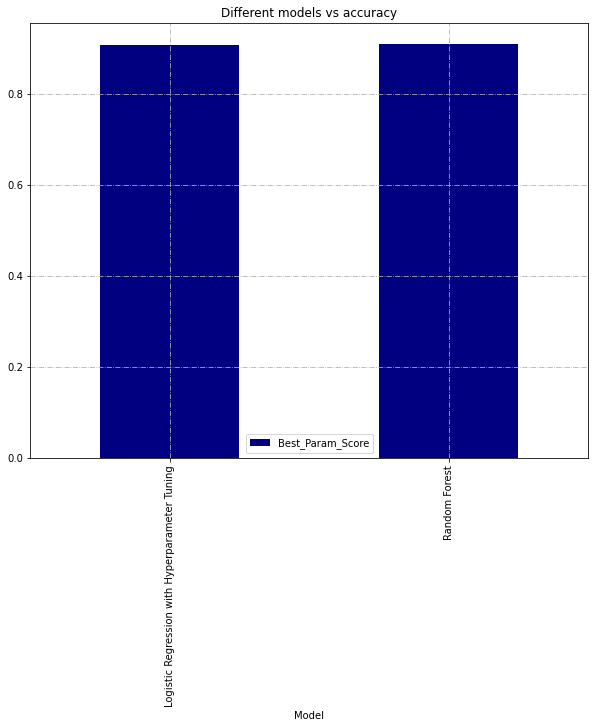

In [93]:
# Let us see this graphically:
result_map=model_bestparams.drop(['Datetime_created','Best_Parameters'],axis='columns')
result_map.plot(x="Model",y='Best_Param_Score',kind='bar',color='navy',figsize=(10,8),title='Different models vs accuracy')
plt.grid(linestyle='-.')

In [71]:
model_bestparams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_created  2 non-null      datetime64[ns]
 1   Model             2 non-null      object        
 2   Best_Parameters   2 non-null      object        
 3   Best_Param_Score  2 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 192.0+ bytes


### Predict and Evaluate with the best model: Log Regressor Classifier (no hyperparameter tuning)

In [165]:
# Prediction by selected model
logreg.fit(X_test_fs, y_test)
y_pred = logreg.predict(X_test_fs)

In [166]:
# Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       120
         1.0       0.83      0.79      0.81        66

    accuracy                           0.87       186
   macro avg       0.86      0.85      0.85       186
weighted avg       0.86      0.87      0.86       186



Text(33.0, 0.5, 'Predicted')

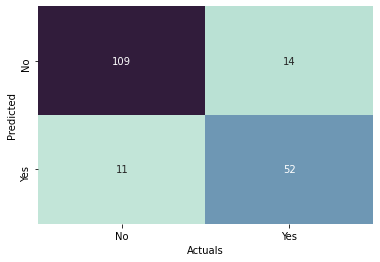

In [167]:
## Confusion Matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat.T, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('Actuals')
plt.ylabel('Predicted')

ROC for best model

In [75]:
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test_fs)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)



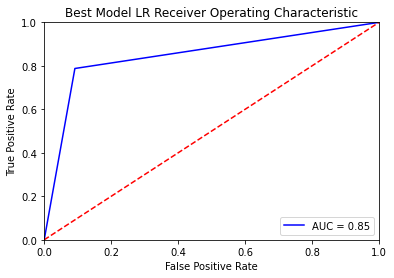

In [76]:
plt.title('Best Model LR Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [77]:
timestampr = datetime.datetime.now()
Result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
Result

,Actual,Predicted
134,0.0,0.0
196,0.0,0.0
84,0.0,0.0
275,0.0,0.0
501,1.0,1.0
...,...,...
240,1.0,1.0
523,0.0,0.0
285,0.0,0.0
442,0.0,0.0


In [78]:
Result1 = Result.rename_axis('IndexNumber')
Result1

,Actual,Predicted
IndexNumber,,
134,0.0,0.0
196,0.0,0.0
84,0.0,0.0
275,0.0,0.0
501,1.0,1.0
...,...,...
240,1.0,1.0
523,0.0,0.0
285,0.0,0.0


In [79]:
pred_df = Result1
pred_df['Created_on'] = timestampr
pred_df['BestModel'] = 'Logistic Regression'
pred_df['Cross_Validation'] = 'Y'
pred_df = pred_df[['Created_on', 'BestModel', 'Cross_Validation', 'Actual', 'Predicted']]

In [80]:
pred_df.reset_index(inplace=True)

pred_df

,IndexNumber,Created_on,BestModel,Cross_Validation,Actual,Predicted
0,134,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0
1,196,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0
2,84,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0
3,275,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0
4,501,2021-05-26 19:47:55.477613,Logistic Regression,Y,1.0,1.0
...,...,...,...,...,...,...
181,240,2021-05-26 19:47:55.477613,Logistic Regression,Y,1.0,1.0
182,523,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0
183,285,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0
184,442,2021-05-26 19:47:55.477613,Logistic Regression,Y,0.0,0.0


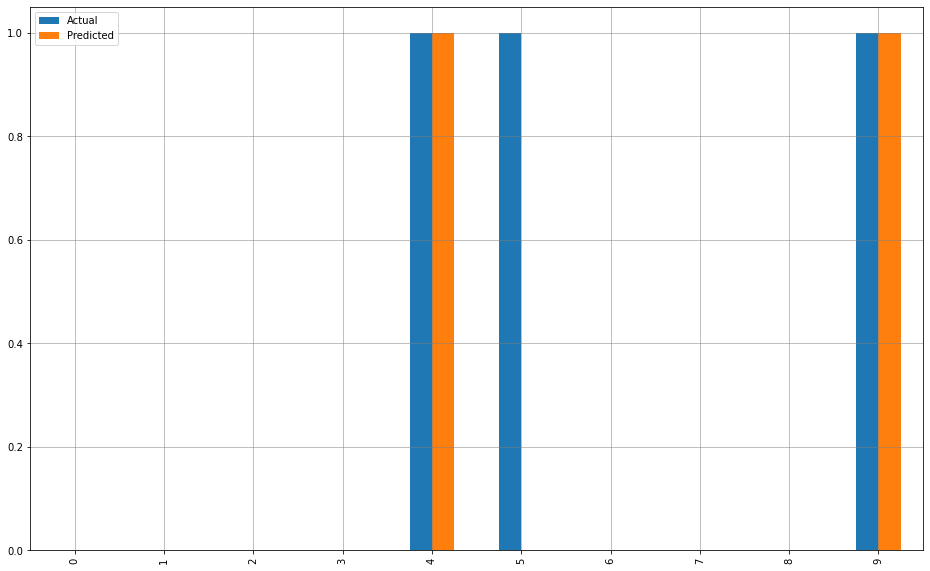

In [131]:
df1 = pred_df[['Actual', 'Predicted']].head(10)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [82]:
df1

,Actual,Predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
5,1.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,1.0,1.0


Code is predicting quite well. Only 1 out of 9 rows are inaccurately predicted.

In [ ]:
['Baseball',
 'Budgeting',
 'Customer_Relationship_Management',
 'Data_Analysis',
 'Databases',
 'Decision_Making',
 'Energy',
 'Football',
 'Healthcare',
 'Information_Technology',
 'Interpersonal_Skills',
 'Logistics_Management',
 'Military_Aviation',
 'Oracle_Database',
 'Performance_Tuning',
 'Soccer',
 'Swimming',
 'Volunteering',
 'Veteran',
 'Disability']

new_input['Baseball', 'Budgeting', 'Customer_Relationship_Management',\
           'Data_Analysis', 'Databases', 'Decision_Making', 'Energy',\
           'Football', 'Healthcare', 'Information_Technology', 'Interpersonal_Skills',\
           'Logistics_Management', 'Military_Aviation', 'Oracle_Database',\
           'Performance_Tuning', 'Soccer', 'Swimming', 'Volunteering', 'Veteran','Disability']

In [192]:
# define dummy inputs

new_input1 = [[0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1]]
new_input2 = [[0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,0,0]]
new_input3 = [[0,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,1,0,0]]
new_input4 = [[0,1,0,1,1,0,0,0,1,1,0,1,1,1,1,0,0,1,1,0]]
new_input5 = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]]
new_input6 = [[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]]
new_input7 = [[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]]

from sklearn.datasets import make_blobs

# create the inputs and outputs
X1, y1 = make_blobs(n_samples=10, centers=20, n_features=20, random_state=2)

# summarize the shape of the arrays
print(X1.shape, y1.shape)

# fit model
logreg.fit(X1, y1)

# make predictions on the entire training dataset
ypred1 = logreg.predict(X1)
# connect predictions with outputs
for i in range(10):
    print(X1[i], ypred1[i])

In [193]:
# get prediction for new input
new_output = logreg.predict(new_input1)


In [170]:
print(new_input1, new_output)

[[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]] [1.]


In [175]:
print(new_input2, new_output)

[[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]] [1.]


In [177]:
print(new_input3, new_output)

[[0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]] [1.]


In [179]:
print(new_input4, new_output)

[[0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]] [1.]


In [186]:
print(new_input5, new_output)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]] [0.]


In [191]:
print(new_input6, new_output)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]] [1.]


In [194]:
print(new_input7, new_output)

[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]] [0.]


#### CONFUSION MATRIX

A confusion matrix is a summary of prediction results on a classification problem.

Positive (P) : Observation is positive (for example: has Successful Interview).

Negative (N) : Observation is not positive (for example: has no Successful Interview).

True Positive (TP) : Observation is positive, and is predicted to be positive.

False Negative (FN) : Observation is positive, but is predicted negative.

True Negative (TN) : Observation is negative, and is predicted to be negative.

False Positive (FP) : Observation is negative, but is predicted positive.

### Get and plot features importances

X = df.drop(['Interview'], axis=1) # input

In [108]:
# Creating the feature importances dataframe
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X_df.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=False)

Wall time: 170 ms


<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

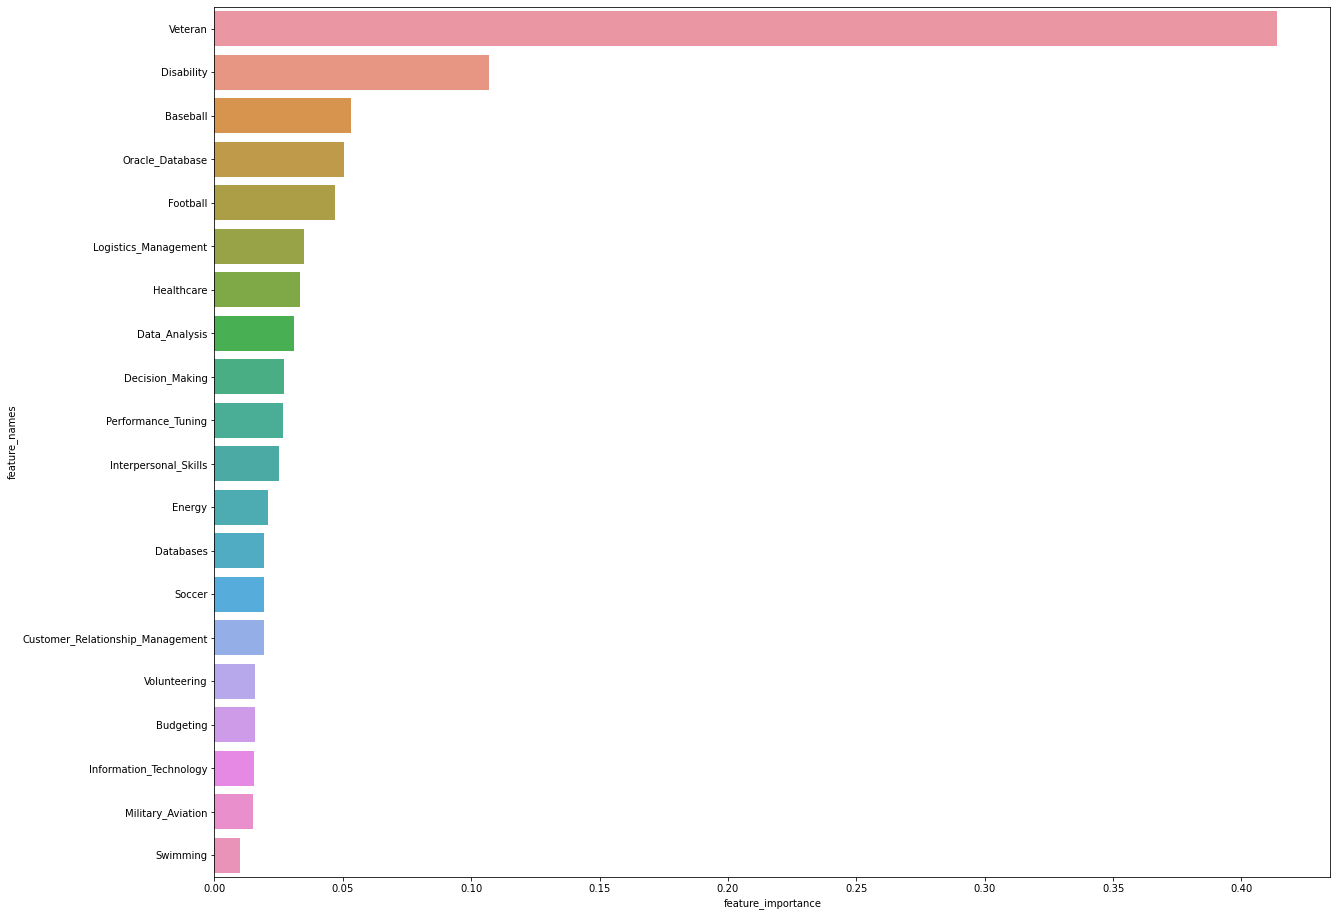

In [110]:
%%time
plt.figure(figsize=(20,16))
sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])

top_10_corr = feat_imp_sorted.head(20)

plt.figure(figsize=(20,18))
sns.barplot(x=top_10_corr['feature_importance'], y=top_10_corr['feature_names'])

So the top 20 highest feature importance.

#### Visualization of Confusion Matrix

plt.figure(figsize=(20,15))

plt.suptitle("Confusion Matrixes", fontsize=18)

plt.subplot(2,3,1)
plt.title("Logistic Regression (HP) Confusion Matrix")
sns.heatmap(lrhp_cm, cbar=False, annot=True, cmap="PuBuGn", fmt="d")

plt.subplot(2,3,2)
plt.title("Random Forest Classification Confusion Matrix")
sns.heatmap(rf_cm, cbar=False, annot=True, cmap="PuBuGn", fmt="d")

plt.subplot(2,3,3)
plt.title("Random Forest (HP) Classification Confusion Matrix")
sns.heatmap(rfhp_cm, cbar=False, annot=True, cmap="PuBuGn", fmt="d")

plt.subplot(2,3,4)
plt.title("BestModel: Logistic Regression Confusion Matrix")
sns.heatmap(lr_cm, cbar=False, annot=True, cmap="PuBuGn", fmt="d")


plt.show()

# Interface to SQL

#### Create logfile in SQL

In [83]:
#1. Start/Open connection Python to SQL

connx = pyodbc.connect('Driver={SQL Server};'
                      'Server=.;'
                      'Database=Interview;'
                      'Trusted_Connection=yes;'
                      'MARS_Connection=Yes;')

cursor = connx.cursor()

#create table metrics_log in SQL

cursor.execute('''

           CREATE TABLE Interview.int.metrics
           (
           RUNID int IDENTITY(1,1) NOT NULL PRIMARY KEY,
           Created_on DATETIME NOT NULL,
           Model char(50) NOT NULL,
           Training_Accuracy float NULL,
           Testing_Accuracy float NULL,
           Precision float NULL,
           Recall float NULL,
           F1_score float NULL,
           Training_Time_s float NULL,
           Best_params nVarchar(MAX),
           Optimizer_used char(15),
           Cross_Validation char(3) NOT NULL
           )

           ''')
connx.commit()

cursor.execute("ALTER TABLE " + 'Interview.int.metrics' + " ADD " + 'AUC_ROC' + " " + 'float')
connx.commit()

#create table GridSearch_log in SQL

cursor.execute('''

           CREATE TABLE Interview.int.GridSearch
           (
           RUNID int IDENTITY(1,1) NOT NULL PRIMARY KEY,
           Created_on DATETIME NOT NULL,
           Model nvarchar(50),
           Best_params nvarchar(500),
           Best_score float
           
           )

           ''')


connx.commit()

#create table Baseline_model in SQL

cursor.execute('''

           CREATE TABLE Interview.int.BaselineModel
           (
           RUNID int IDENTITY(1,1) NOT NULL PRIMARY KEY,
           Created_on datetime2(7) NOT NULL,
           Cross_Validation char(3) NOT NULL,
           Baseline_Model nvarchar(50),
           cv1 float,
           cv2 float,
           cv3 float,
           cv4 float,
           cv5 float,
           mean float,
           std float,
           
           )

           ''')



connx.commit()

#create table Predictions in SQL

cursor.execute('''

           CREATE TABLE Interview.int.Predictions
           (
           RUNID int IDENTITY(1,1) NOT NULL PRIMARY KEY,
           Created_on DATETIME,
           IndexNum int NOT NULL,
           BestModel nvarchar(50),
           Cross_Validation char(3) NOT NULL,
           Actual_val float,
           Predicted_val float,
           )

           ''')

connx.commit()

In [84]:
model_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_created  2 non-null      datetime64[ns]
 1   Model             2 non-null      object        
 2   Training_Acc      2 non-null      float64       
 3   Testing_Acc       2 non-null      float64       
 4   Precision         2 non-null      float64       
 5   Recall            2 non-null      float64       
 6   F1_Score          2 non-null      float64       
 7   Training_Time     2 non-null      float64       
 8   Best_Parameters   2 non-null      object        
 9   AUC_ROC           2 non-null      float64       
 10  Optimizer_used    2 non-null      object        
 11  Cross_Validation  2 non-null      object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 320.0+ bytes


In [85]:
# Insert model_metrics Dataframe into SQL Server:

insert_metrics = '''INSERT INTO Interview.int.metrics (Created_on, Model, Training_Accuracy, Testing_Accuracy, Precision, Recall, F1_score, Training_Time_s, Best_params, Optimizer_used, Cross_Validation, AUC_ROC) values(?,?,?,?,?,?,?,?,?,?,?,?);'''

for met in model_metrics.iterrows():
    values = (met[1]['Datetime_created'], met[1]['Model'], met[1]['Training_Acc'], met[1]['Testing_Acc'], met[1]['Precision'], met[1]['Recall'], met[1]['F1_Score'], met[1]['Training_Time'], met[1]['Best_Parameters'], met[1]['Optimizer_used'], met[1]['Cross_Validation'], met[1]['AUC_ROC'])
    cursor.execute(insert_metrics, values)
    connx.commit()
    

In [86]:
model_bestparams

,Datetime_created,Model,Best_Parameters,Best_Param_Score
0,2021-05-26 19:44:55.609980,Logistic Regression with Hyperparameter Tuning,"{'C': 1.0, 'penalty': 'l2'}",0.908467
1,2021-05-26 19:45:11.527853,Random Forest,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.910162


In [87]:
model_bestparams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_created  2 non-null      datetime64[ns]
 1   Model             2 non-null      object        
 2   Best_Parameters   2 non-null      object        
 3   Best_Param_Score  2 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 192.0+ bytes


In [88]:
# Insert model_bestparams Dataframe into SQL Server:

insert_query = '''INSERT INTO Interview.int.GridSearch (Created_on, Model, Best_params, Best_score) values(?,?,?,?);'''

for res in model_bestparams.iterrows():
    values = (res[1]['Datetime_created'], res[1]['Model'], res[1]['Best_Parameters'], res[1]['Best_Param_Score'])
    cursor.execute(insert_query, values)
    connx.commit()



In [89]:
baseline_model['BaseLine_Model']

0    Logistic Regression
Name: BaseLine_Model, dtype: object

In [90]:
###### Insert baseline_model Dataframe into SQL Server:

insert_blm = '''INSERT INTO Interview.int.BaselineModel (Created_on, Cross_Validation, BaseLine_Model, cv1,cv2,cv3,cv4,cv5,mean,std) values(?,?,?,?,?,?,?,?,?,?);'''

for res in baseline_model.iterrows():
    values = (res[1]['Created_on'], res[1]['Cross_Validation'], res[1]['BaseLine_Model'], res[1]['cv1'], res[1]['cv2'], res[1]['cv3'], res[1]['cv4'], res[1]['cv5'], res[1]['mean'], res[1]['std'])
    cursor.execute(insert_blm, values)
    connx.commit()

In [91]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   IndexNumber       186 non-null    int64         
 1   Created_on        186 non-null    datetime64[ns]
 2   BestModel         186 non-null    object        
 3   Cross_Validation  186 non-null    object        
 4   Actual            186 non-null    float64       
 5   Predicted         186 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 8.8+ KB


In [92]:
###### Insert Predictions Dataframe into SQL Server:

insert_pred = '''INSERT INTO Interview.int.Predictions (Created_on, IndexNum, BestModel, Cross_Validation, Actual_val, Predicted_val) values(?,?,?,?,?,?);'''

for res in pred_df.iterrows():
    values = (res[1]['Created_on'], res[1]['IndexNumber'], res[1]['BestModel'], res[1]['Cross_Validation'], res[1]['Actual'], res[1]['Predicted'])
    cursor.execute(insert_pred, values)
    connx.commit()